# Removed Data Analysis

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import clean_data as cda

## Import Data

In [2]:
COLUMNS_TO_IMPORT = ['mac_address', 'date_time', 'location', 'store_id', 'x', 'y']

shopper_df = pd.read_csv('../data/bag_mus_12-22-2016.csv', usecols=COLUMNS_TO_IMPORT)
shopper_df.date_time = shopper_df.date_time.astype('datetime64[ns]')

#hl_df = shopper_df[shopper_df['location'] == 'Home & Leisure']
signal_df = shopper_df[shopper_df['location'] == 'Mall of Mauritius']
#p_df = shopper_df[shopper_df['location'] == 'Phoenix Mall']

minimum = 10
speed = 3

## Removal of Duplicate Data Points

Occasionally there are points in the data set that are identical, there is no need to retain these. We remove them.

In [3]:
signal_df = cda.remove_duplicates(signal_df)

## Background Noise Removal

Below is a histogram showing the number of shoppers against time for one of the shopping malls. The non-zero count in the early hours of the morning before the shopping mall opens suggests these are false signals. We opt to remove all mac addresses associated with these out of hour signals.

Text(0,0.5,'Count of shoppers (no.)')

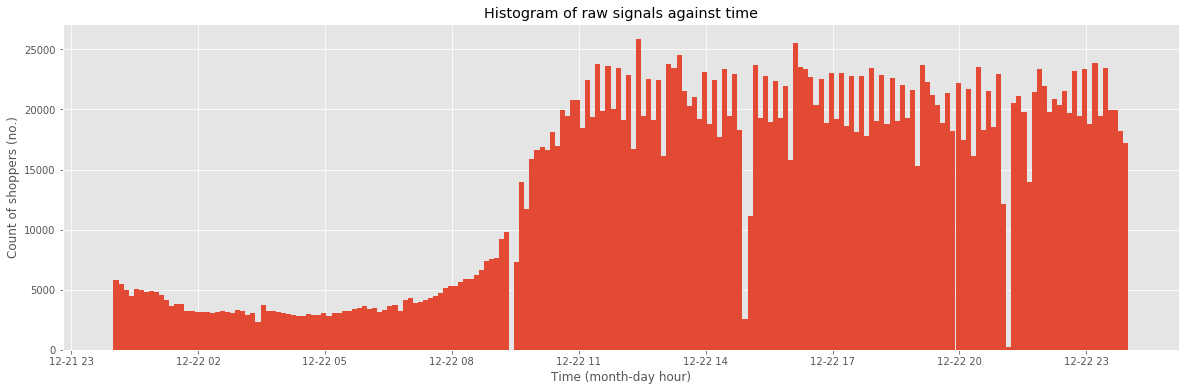

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax = signal_df.date_time.hist(bins=200, ax=axes)
ax.set_title('Histogram of raw signals against time')
ax.set_xlabel('Time (month-day hour)')
ax.set_ylabel('Count of shoppers (no.)')

With these signals removed, the same plot seems more plausible:

0.696734819795526 kept
142614 11538


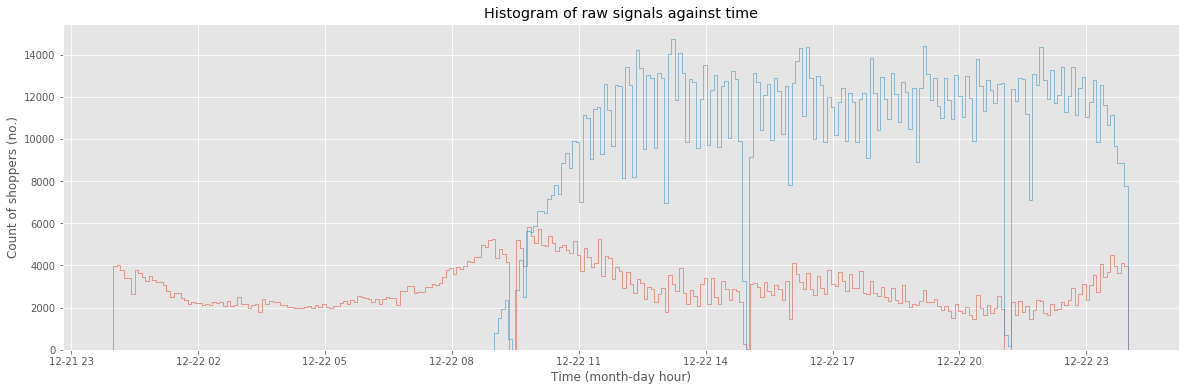

In [5]:
signal_good_df, signal_bad_df = cda.remove_outside_hours(signal_df, '09:00:00', '23:59:00', analysis=True)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))

good_bins = int((signal_bad_df.date_time.max() - signal_bad_df.date_time.min()).seconds / (60 * 5))
signal_bad_df.date_time.hist(bins=good_bins, ax=axes, histtype='step')

bad_bins = int((signal_good_df.date_time.max() - signal_good_df.date_time.min()).seconds / (60 * 5))
signal_good_df.date_time.hist(bins=bad_bins, ax=axes, histtype='step')

axes.set_title('Histogram of raw signals against time')
axes.set_xlabel('Time (month-day hour)')
axes.set_ylabel('Count of shoppers (no.)')

print(len(signal_good_df)/len(signal_df), 'kept')

print(len(signal_good_df.groupby('mac_address')), len(signal_bad_df.groupby('mac_address')))

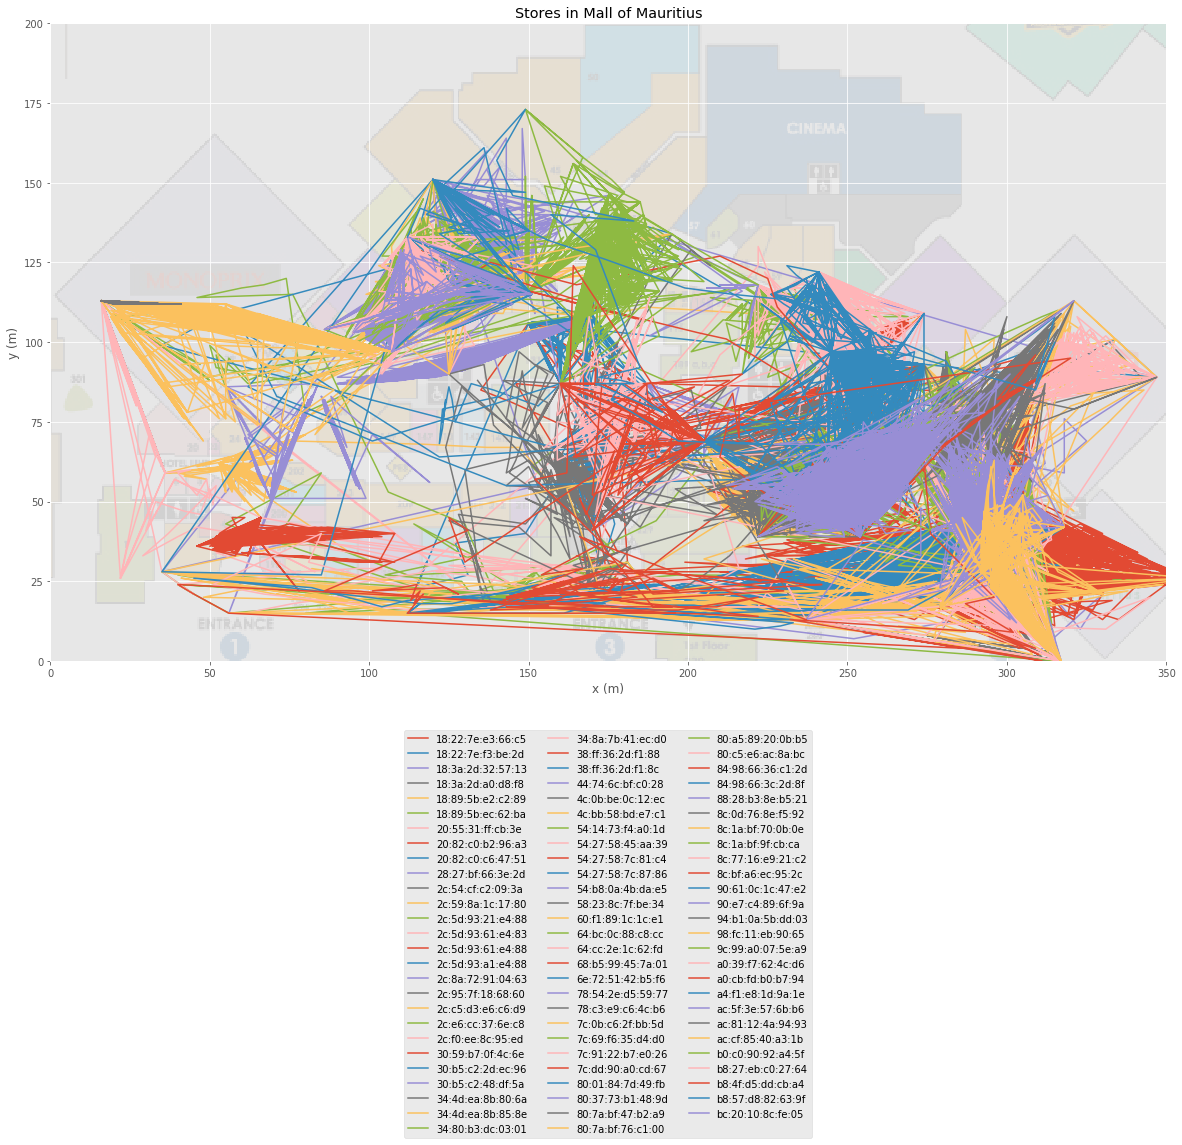

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

img = mpimg.imread("../images/mall_of_mauritius_map.png")
axes.imshow(img[::-1], origin='lower', extent=[-77,470,-18,255], alpha=0.1)

signal_group_mac = signal_df[
    signal_df.mac_address.isin(signal_bad_df.mac_address.drop_duplicates().tolist()[20:100])
].groupby('mac_address') 

for title, group in signal_group_mac:
    group.plot(x='x', y='y', ax=axes, label=title)
    
axes.set_title('Stores in Mall of Mauritius')
axes.set_xlabel('x (m)')
axes.set_ylabel('y (m)')
axes.set_xlim([0,350])
axes.set_ylim([0,200])
axes.legend(loc='upper center', markerscale=10., ncol=3, bbox_to_anchor=(0.5, -0.1));

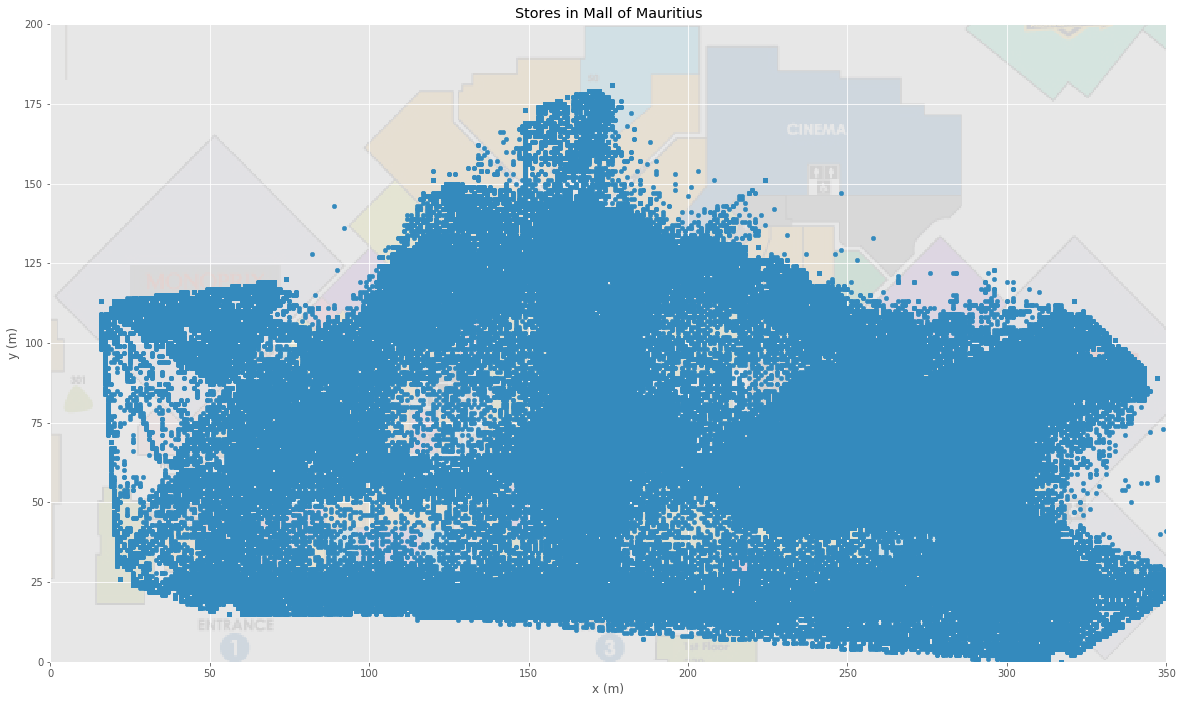

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

img = mpimg.imread("../images/mall_of_mauritius_map.png")
axes.imshow(img[::-1], origin='lower', extent=[-77,470,-18,255], alpha=0.1)

signal_bad_df.plot.scatter('x', 'y', ax=axes)
    
axes.set_title('Stores in Mall of Mauritius')
axes.set_xlabel('x (m)')
axes.set_ylabel('y (m)')
axes.set_xlim([0,350])
axes.set_ylim([0,200])
axes.legend(loc='upper center', markerscale=10., ncol=3, bbox_to_anchor=(0.5, -0.1));

## Counts vs length of stay

In [8]:
def count_vs_stay_length(df, good_bad_df):
    group_mac = df[
        df.mac_address.isin(good_bad_df.mac_address.drop_duplicates().tolist())
    ].groupby('mac_address')

    mac_info = pd.concat([
        group_mac.size(), 
        group_mac.date_time.min(), 
        group_mac.date_time.max()
    ], axis=1)

    mac_info.columns = ['counts', 'min_time', 'max_time']

    mac_info['stay_length'] = (mac_info.max_time - mac_info.min_time).dt.seconds
    
    return mac_info

142614 11538


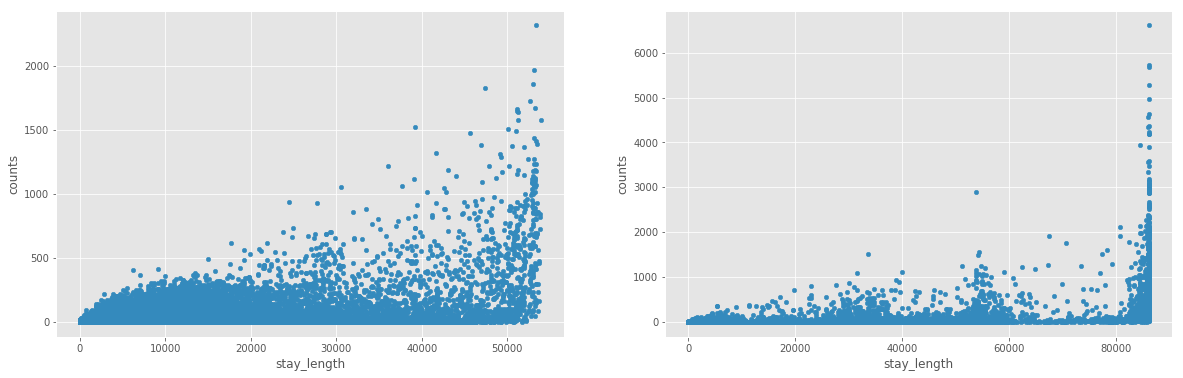

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
good_group_mac_info = count_vs_stay_length(signal_df, signal_good_df)
good_group_mac_info.plot.scatter('stay_length', 'counts', ax=axes[0])

bad_group_mac_info = count_vs_stay_length(signal_df, signal_bad_df)
bad_group_mac_info.plot.scatter('stay_length', 'counts', ax=axes[1])

print(len(good_group_mac_info), len(bad_group_mac_info))

In [25]:
high_stay_length_mac = bad_group_mac_info.sort_values('stay_length', ascending=False)[:500].index.drop_duplicates().tolist()

c:\users\tvb\envs\venv-msci\lib\site-packages\matplotlib\axes\_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=16.0, right=16.0
  'left=%s, right=%s') % (left, right))


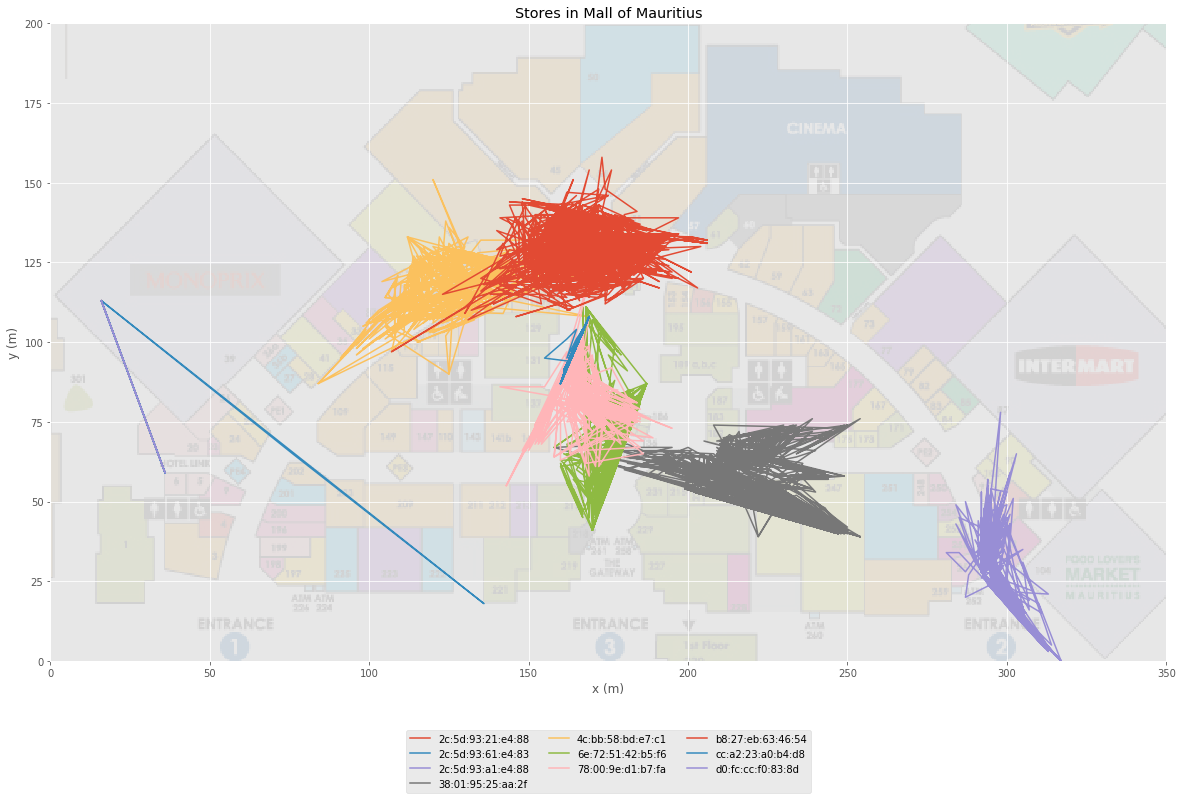

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))

img = mpimg.imread("../images/mall_of_mauritius_map.png")
axes.imshow(img[::-1], origin='lower', extent=[-77,470,-18,255], alpha=0.1)

signal_group_mac = signal_df[
    signal_df.mac_address.isin(high_stay_length_mac[30:40])
].groupby('mac_address') 

for title, group in signal_group_mac:
    group.plot(x='x', y='y', ax=axes, label=title)
    
axes.set_title('Stores in Mall of Mauritius')
axes.set_xlabel('x (m)')
axes.set_ylabel('y (m)')
axes.set_xlim([0,350])
axes.set_ylim([0,200])
axes.legend(loc='upper center', markerscale=10., ncol=3, bbox_to_anchor=(0.5, -0.1));

In [12]:
mac_address_df = pd.read_csv('../data/mac_address_cross_reference.csv')

In [13]:
signal_df['mac_address_short'] = signal_df.mac_address.str.replace(':', '').str.upper().str[:6]
signal_df = signal_df.merge(mac_address_df, how='left', left_on='mac_address_short', right_on='Assignment')
signal_df.drop(['Registry', 'Assignment', 'Organization Address'], inplace=True, axis=1)
signal_df.rename(columns={'Organization Name': 'manufacturer'}, inplace=True)

In [27]:
signal_df[signal_df.mac_address.isin(high_stay_length_mac)].groupby('mac_address').head(1).manufacturer.value_counts()

Samsung Electronics Co.,Ltd                                       125
Ruckus Wireless                                                    64
HUAWEI TECHNOLOGIES CO.,LTD                                        50
Apple, Inc.                                                        25
HTC Corporation                                                    22
LG Electronics (Mobile Communications)                             20
SAMSUNG ELECTRO-MECHANICS(THAILAND)                                16
NETGEAR                                                            12
D-Link International                                               11
TP-LINK TECHNOLOGIES CO.,LTD.                                       8
Sony Mobile Communications AB                                       8
zte corporation                                                     7
Hon Hai Precision Ind. Co.,Ltd.                                     6
AzureWave Technology Inc.                                           6
TCT mobile ltd      

## Unrealistic Pedestrain Speeds

Typical jogging speeds are around 3$ms^{-1}$. By grouping the dataset in terms of mac address and sorting by time, we can evaluate the change in euclidean distance between any two timestamps and subsequently estimate an average velocity for the mac address between each data point. We discard all mac addresses that contain velocities exceeding this jogging speed. 

In [ ]:
p_df = cda.remove_sparse_data(p_df, 10)

speeds = cda.remove_unrealistic_speeds(p_df, 3, notebook = True)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
axes[0].hist(speeds, bins = 50)
axes[0].set_title('Users Average Speeds')
axes[0].set_xlabel('Speed' + r'($ms^{-1}$)')
axes[0].set_ylabel('Count of shoppers (no.)')

p_df = cda.remove_unrealistic_speeds(p_df, 3)
speeds = cda.remove_unrealistic_speeds(p_df, 3, notebook = True)

axes[1].hist(speeds, bins = 50)
axes[1].set_title("User Average Speeds")
axes[1].set_xlabel('Speed' + r'($ms^{-1}$)')
axes[1].set_ylabel('Count of shoppers (no.)')

## Sparse Data

Another functionality we introduce into our cleaning module is the ability to remove mac addresses for which there are not many data points. 1 or even 2 data points for a given person tell us nothing about the movement profile of the individual, let alone the macroscopic data attributes. For initial purposes, we set a threshold of 10 data points for each mac ID. For continuity purposes, the function for this is displayed in line 12 of this notebook. 

## Outstanding Issues

- Data points from outside the physical confines of the mall: Plots of the data show that there are relatively few points that fit into this category, but ideally we want to remove them either way. For this we will need information of the mall schematics.
- Stationary IDs: Store clerks, security guards etc. may spend lots of time in one place and are not really of interest to us. These should be removed
- There still appear to be inherrent errors in the dataset that we may not be able to do anything about. Above it seems that there may have been a fault in the harvesting equipment at around 1pm. This, or there is a causal link between the time and the reduction of counts e.g. lunchtime? 
- In the first histogram above, which includes the data that we nominally classified as corresponding to errant background, appears to be bimodal. When we trim the mac addresses, the second mode disappears and we are left with a distribution resembling a less skewed normal distribution. Naively, this leads us to believe that the data corresponding to out of hour signals is not a systematic background noise but itself has a distribution. It would be instructive to look at the profile of the data that we are discarding (this case in particular but also in general); this will only aid our understanding of the overall data set we are working with.